<a href="https://colab.research.google.com/github/ttn045/swe_assign/blob/main/AssignSWE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Nom:** SALHI <br>
**Prenom:** Elmootez Belleh <br>

### Importation de tous les bibleotheques necessaires

In [1]:
import numpy as np
from PIL import Image
import warnings
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from sklearn.metrics import pairwise_distances_argmin
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

### Chargement et prétraitement des données MNIST

In [2]:
# Charger les données MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
# Normaliser les images en les mettant à l'échelle de 0 à 1
x_train = x_train / 255.0
x_test = x_test / 255.0


In [4]:
# Convertir les labels en vecteurs one-hot encoding
# (Pour pouvoir les representer avec des nombre binaire)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

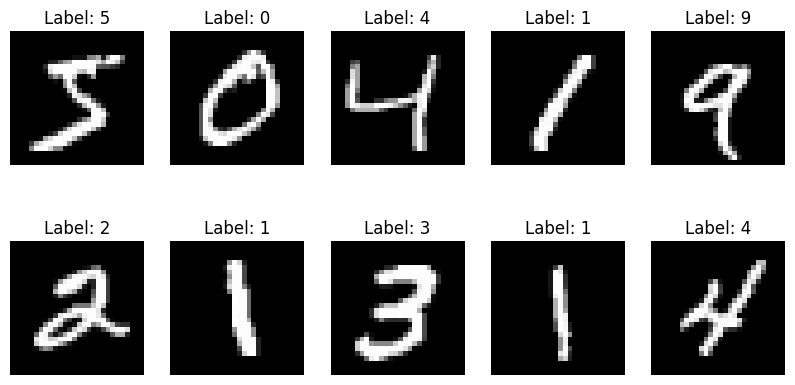

In [5]:
# Afficher quelques exemples d'images et leurs labels
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i].argmax()}")
    plt.axis('off')
plt.show()

### Construction du modèle MLP compact

In [6]:
# Créer le modèle
model = Sequential([
    Flatten(input_shape=(28, 28)),  # Aplatir les images 28x28 en vecteurs de 784 éléments
    Dense(64, activation='relu'),   # Couche cachée avec 64 neurones et une fonction d'activation ReLU
    Dense(10, activation='softmax') # Couche de sortie avec 10 neurones (une pour chaque chiffre) et une fonction d'activation softmax
])

In [7]:
# Compiler le modèle
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Entraînement du modèle

In [8]:
# Entraîner le modèle
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
1500/1500 [==============================] - 16s 7ms/step - loss: 0.3419 - accuracy: 0.9036 - val_loss: 0.1837 - val_accuracy: 0.9475
Epoch 2/10
1500/1500 [==============================] - 8s 6ms/step - loss: 0.1626 - accuracy: 0.9530 - val_loss: 0.1576 - val_accuracy: 0.9544
Epoch 3/10
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1218 - accuracy: 0.9638 - val_loss: 0.1266 - val_accuracy: 0.9621
Epoch 4/10
1500/1500 [==============================] - 15s 10ms/step - loss: 0.0947 - accuracy: 0.9720 - val_loss: 0.1112 - val_accuracy: 0.9674
Epoch 5/10
1500/1500 [==============================] - 14s 9ms/step - loss: 0.0777 - accuracy: 0.9771 - val_loss: 0.1059 - val_accuracy: 0.9697
Epoch 6/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0640 - accuracy: 0.9813 - val_loss: 0.0991 - val_accuracy: 0.9705
Epoch 7/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0551 - accuracy: 0.9837 - val_loss: 0.0959 - val_accur

### Évaluation du modèle

In [9]:
# Evaluation du modele sur les données de test
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

313/313 [==============================] - 1s 2ms/step - loss: 0.0933 - accuracy: 0.9728
Test accuracy: 0.9728


### Affichage des courbes d'apprentissage



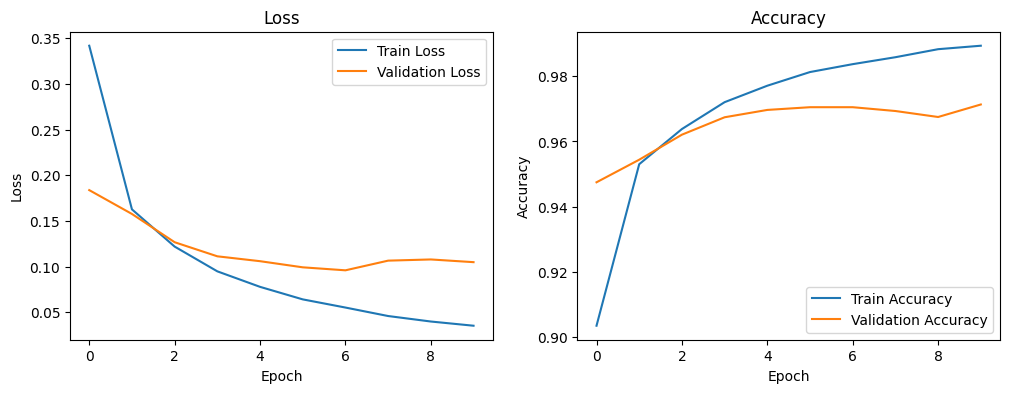

In [10]:
# Afficher les courbes de perte et de précision
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Prédiction sur de nouvelles *images*

In [11]:
# Prédire les labels des images de test
predictions = model.predict(x_test)

313/313 [==============================] - 1s 2ms/step


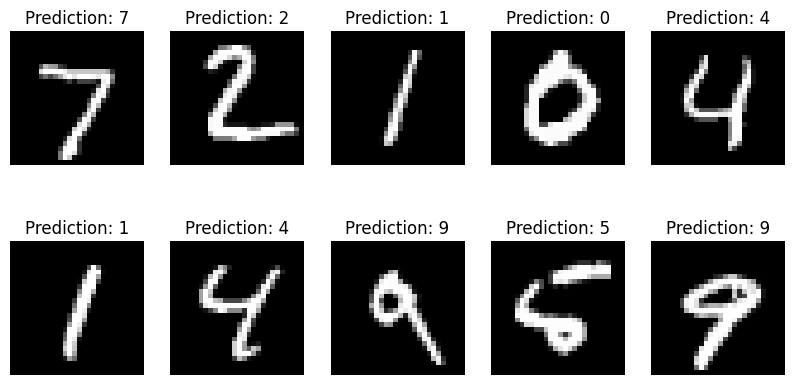

In [12]:
# Afficher quelques exemples de prédictions
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_test[i], cmap='gray')
    plt.title(f"Prediction: {predictions[i].argmax()}")
    plt.axis('off')
plt.show()

### Chargement et prétraitement des images

In [13]:
# Charger une image locale
dog = "/content/sample_data/dogPicture.png"
image = Image.open(dog)

In [14]:

# Convertion de l'image en tableau de données
image = np.array(image, dtype=np.float64) / 255

# Si l'image est en niveaux de gris, la convertir en RGB
if image.ndim == 2:
    print("l'image est en niveau de gris")
    image = np.stack((image,) * 3, axis=-1)

elif image.ndim != 3 or image.shape[2] != 3:
    raise ValueError("L'image doit être en RGB ou en niveau de gris")

# Redimensionner l'image pour réduire le temps de calcul
image = image[::3, ::3]

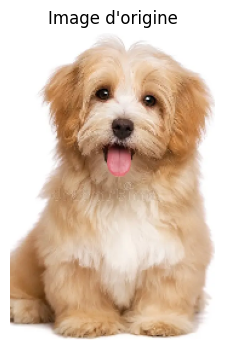

In [15]:
# Afficher l'image d'origine
plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.title("Image d'origine")
plt.axis('off')
plt.show()

Implémentation de l'algorithme k-means

In [16]:
def recreate_image(codebook, labels, w, h):
    # Recrée l'image à partir des labels et du codebook
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

In [17]:
def apply_kmeans(image, n_colors):
    # Applique k-means sur l'image avec n_colors clusters
    w, h, d = original_shape = tuple(image.shape)
    assert d == 3
    image_array = np.reshape(image, (w * h, d))

    # Utiliser une sous-échantillon de l'image pour un clustering plus rapide
    image_array_sample = shuffle(image_array, random_state=0)[:1000]

    # Appliquer k-means
    kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
    labels = kmeans.predict(image_array)

    return recreate_image(kmeans.cluster_centers_, labels, w, h)

### Application de k-means avec différentes valeurs de K

In [18]:
# Filtrer les avertissements spécifiques
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.cluster._kmeans")

In [19]:
# Définir les valeurs de K
k_values = [2,3,4,5,10,20]

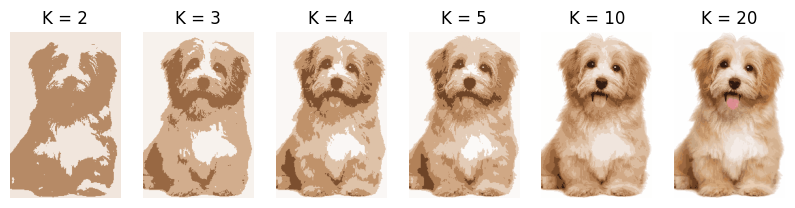

In [20]:
# Appliquer k-means avec différentes valeurs de K et afficher les résultats
plt.figure(figsize=(10, 10))
for i, k in enumerate(k_values):
    plt.subplot(1, 6, i+1)
    clustered_image = apply_kmeans(image, k)
    plt.imshow(clustered_image)
    plt.title(f"K = {k}")
    plt.axis('off')